# Introduction

Basically we are trying to find the best algorithm to classify the inhibitor types in our binary dataset from KinCoRe that we preprocessed. Here, we are trying out using Logistic Regression, Support Vector Machine, and Random Forest.

The workflow is as follows:
1. load packages, directory, and dataset
2. find the best combination of sampling and standardization/normalization methods that yields the best baseline model
3. run hyperparameter tuning for our model to get the highest metrics score
4. repeat with different algorithms

# Load dataset and directories

In [1]:
# general data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management packages
import csv, sys
import os
import copy
import pickle

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# modeling
from sklearn import preprocessing, model_selection, feature_selection, metrics
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# misc
from textwrap import wrap
import time


In [2]:
os.chdir('../data')

In [7]:
data_fb = pd.read_csv('data_binding_fp-03.csv').drop(columns=['Unnamed: 0'])
data_fb = data_fb.replace({'Type1.5_Back':'Type1.5', 'Type1.5_Front':'Type1.5'})
data_fb

,lig_smiles,LigandType,lig_at,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5,2169,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,...,7.034388,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,7.500000
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,...,0.000000,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.083333
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,...,6.529419,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


<AxesSubplot:xlabel='LigandType', ylabel='count'>

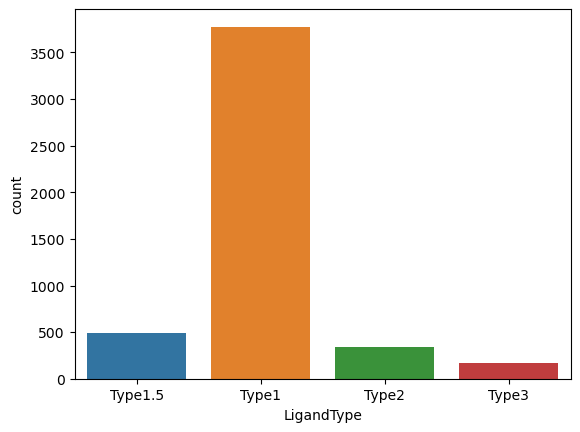

In [8]:
sns.countplot(data_fb, x='LigandType')

from here we can see that there are several columns that need to be dropped for the next step, such as `Unnamed: 0` and `lig_smiles`. The column `LigandType` needs to be separated as a target. The rest (209 columns) are features we'll use in the model.

# 0. preprocess data

workflow in this step is the following:
1. drop duplicate and null rows
2. drop feature that begins with `Unnamed` (since it was generated automatically when we did not reset the index in the last step before saving the data from the previous step into csv)
3. encode target using integer (0,1)
4. separate features and target
5. remove features which values don't have variation
6. remove feature that has low correlation with other features
7. split data into train-validation and test set
8. split data into train and validation set

In [9]:
def data_preprocessing(data,
                       target='LigandType', 
                       col_to_drop=['lig_smiles'],
                       test_size=0.2, 
                       val_size=0.2, 
                       random_state=0,
                       anova=True,
                       ):
    '''
    preprocess data from the previous workflow

    Args:
    ----------
      data: pd.DataFrame
        the input data to be preprocesed
      target: str
        target column for the model
      col_to_drop: list
        list of columns to drop
      test_size: float
        test size from the whole input data
      val_size: float
        validation set size from the whole input data
      anova: bool
        initial feature selection option using ANOVA

    Returns:
    ----------
      X_train, X_val, X_test, y_train, y_val, y_test: np.array
        the respective train, validation and test sets
      descnm: np.array
        feature names
    '''

    # drop duplicate rows
    data_ = data.drop_duplicates().dropna()

    # drop cols with 'unnamed'
    colidx_to_drop = [i for i in data.columns if 'Unnamed' in i]

    #encode target
    to_mask = {}

    for i,j in enumerate(data_[target].unique()):
        to_mask.update({j:i})

    data_ = data_.replace(to_mask)

    # separate x and y
    X = data_.loc[:, data_.columns.difference(col_to_drop+[target]+colidx_to_drop)]
    y = data_[target]

    # remove features that don't have variation
    X_out = X.loc[:,X.apply(pd.Series.nunique) != 1]
    mask = X_out.applymap(lambda x: isinstance(x, (int, float)))
    X_out2 = X_out.where(mask)
    X = X_out2.dropna(axis=1)

    if anova == True:
      # anova feature selection
      f_stat, p_val, = f_classif(X, y)

      # get index which probability is lower than p = 0.05
      idx = [i for i,j in enumerate(p_val) if j < 0.05]
      # select column with respective index
      X = X.iloc[:,idx]
    else:
      pass

    # split train-validation and test
    X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    # split train and validation
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainval, y_trainval, test_size = val_size/(1-val_size), random_state=random_state, stratify=y_trainval)

    descnm = np.array(X_train.columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    #return X_trainval, X_test, y_trainval, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test, descnm

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fb)

In [12]:
print(len(y_train))
print(len(y_val))
print(len(y_test))
print(len(y_train)+len(y_val)+len(y_test))

2859
953
953
4765


In [13]:
print(f'0 = {len([i for i in y_train if i == 0])}')
print(f'1 = {len([i for i in y_train if i == 1])}')

print(f'0 = {len([i for i in y_val if i == 0])}')
print(f'1 = {len([i for i in y_val if i == 1])}')

print(f'0 = {len([i for i in y_test if i == 0])}')
print(f'1 = {len([i for i in y_test if i == 1])}')

0 = 292
1 = 2266
0 = 97
1 = 755
0 = 97
1 = 755


# 1. find combination of sampling and standardization methods for a baseline model

In [14]:
def find_model(X_train, y_train, X_val, y_val,
                algorithm = 'logreg',
                multiclass = False,
                kernel = 'rbf',
                solver='liblinear',
                max_iter=10000,
                scaling = True,
                random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'LogisticRegression'
            - Support vector machine: 'SVC'
            - Random forest: 'RandomForestClassification'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        #sampling: str
        #    sampling method you wish to use. Available are:
        #    - smote
        #    - random_over
        #    - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        df_find_model
            A DataFrame of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    def model_(X_train, y_train, X_val, y_val,
                      algorithm = algorithm,
                      multiclass = multiclass,
                      kernel = kernel,
                      solver = solver,
                      sampling = 'SMOTE',
                      max_iter=max_iter,
                      scaling = scaling,
                      random_state=random_state):
        '''
        Find the best combination of sampling and
        standardization methods as a baseline model.

        Args:
        ----------
            X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
                Training and validation data and its targts
            algorithm: str
                The algorithm to use. Available are:
                - Logistic regression: 'logreg'
                - Support vector machine: 'svm'
                - Random forest: 'rf'
            multiclass: bool
                Determining whether the classification is binary or multiclass.
                if `True` then the average metrics is computed as weighted
                if `False` then the average metrics is computed as binary
            kernel: str
                only applies in support vector machine. 
                The kernel you wish to run.
            solver: str
                only applies in logistic regression. 
                The solver you wish to run. Default is 'liblinear'.
            sampling: str
                sampling method you wish to use. Available are:
                - smote
                - random_over
                - random_under
            scaling: bool
                scaling (standardization/normalization) of the data.

        Returns:
        ----------
            dict
                A dictionary of the scores between different sampling and scaling methods 
                across metrics of the training and validation data
        '''

        if type(sampling) == str:
            sampling = [sampling]

        for i in sampling:
            if i == 'RandomUnderSampler':
                X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'RandomOverSampler':
                X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'SMOTE':
                X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
            else:
                pass
        
        if algorithm == 'LogisticRegression':
            model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
        elif algorithm == 'SVC':
            model = SVC(kernel=kernel, random_state=random_state)
        else:
            model = RandomForestClassifier(random_state=random_state)
            scaling = False

        # scaling
        if scaling == False:
            train_scaled = {'none':X_train}
            val_scaled = {'none':X_val}
        else:
            scaler = preprocessing.MaxAbsScaler()
            X_train_MAS = scaler.fit_transform(X_train)
            X_val_MAS = scaler.transform(X_val)

            scaler = preprocessing.MinMaxScaler()
            X_train_MMS = scaler.fit_transform(X_train)
            X_val_MMS = scaler.transform(X_val)

            scaler = preprocessing.StandardScaler()
            X_train_SS = scaler.fit_transform(X_train)
            X_val_SS = scaler.transform(X_val)

            scaler = preprocessing.Normalizer()
            X_train_NORM = scaler.fit_transform(X_train)
            X_val_NORM = scaler.transform(X_val)

            scaler = preprocessing.MaxAbsScaler()
            X_train_NMAS = scaler.fit_transform(X_train_NORM)
            X_val_NMAS = scaler.transform(X_val_NORM)

            scaler = preprocessing.MinMaxScaler()
            X_train_NMMS = scaler.fit_transform(X_train_NORM)
            X_val_NMMS = scaler.transform(X_val_NORM)

            scaler = preprocessing.StandardScaler()
            X_train_NSS = scaler.fit_transform(X_train_NORM)
            X_val_NSS = scaler.transform(X_val_NORM)

            scaler = preprocessing.Normalizer()
            X_train_MASNORM = scaler.fit_transform(X_train_MAS)
            X_val_MASNORM = scaler.transform(X_val_MAS)

            scaler = preprocessing.Normalizer()
            X_train_MMSNORM = scaler.fit_transform(X_train_MMS)
            X_val_MMSNORM = scaler.transform(X_val_MMS)

            scaler = preprocessing.Normalizer()
            X_train_SSNORM = scaler.fit_transform(X_train_SS)
            X_val_SSNORM = scaler.transform(X_val_SS)
            

            train_scaled = {
                'none':X_train,
                'MaxAbsScaler':X_train_MAS,
                'MinMaxScaler':X_train_MMS,
                'StandardScaler':X_train_SS,
                'Normalizer':X_train_NORM,
                'Normalizer + MaxAbsScaler':X_train_NMAS,
                'Normalizer + MinMaxScaler':X_train_NMMS,
                'Normalizer + StandardScaler':X_train_NSS,
                'MaxAbsScaler + Normalizer':X_train_MASNORM,
                'MinMaxScaler + Normalizer':X_train_MMSNORM,
                'StandardScaler + Normalizer':X_train_SSNORM,
                }
            
            val_scaled = {
                'none':X_val,
                'MaxAbsScaler':X_val_MAS,
                'MinMaxScaler':X_val_MMS,
                'StandardScaler':X_val_SS,
                'Normalizer':X_val_NORM,
                'Normalizer + MaxAbsScaler':X_val_NMAS,
                'Normalizer + MinMaxScaler':X_val_NMMS,
                'Normalizer + StandardScaler':X_val_NSS,
                'MaxAbsScaler + Normalizer':X_val_MASNORM,
                'MinMaxScaler + Normalizer':X_val_MMSNORM,
                'StandardScaler + Normalizer':X_val_SSNORM,
                }

        output_dict= {
            'sampling': [],
            'scaling': [],
            'train_accuracy': [],
            'train_f1': [],
            'train_ba':[],
            'train_mcc':[],
            'train_cf': [],
            'val_accuracy':[],
            'val_f1':[],
            'val_ba':[],
            'val_mcc':[],
            'val_cf': [],
        }

        for sampl in sampling:
            for scaler, scaled in train_scaled.items():
                for v_scaled in val_scaled.values():
                    fit = model.fit(scaled, y_train)
                    y_pred = fit.predict(scaled)
                    y_val_pred = fit.predict(v_scaled)


                    # calculate statistical metrics accuracy for training set
                    train_accuracy = metrics.accuracy_score(y_train, y_pred)
                    val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

                    if multiclass == True:
                        # calculate statistical metrics for training set
                        train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                        train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                        train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                        train_cf = metrics.confusion_matrix(y_train, y_pred)

                        # calculate statistical metrics for val set
                        val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                        val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                        val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                        val_cf = metrics.confusion_matrix(y_val, y_val_pred)
                    else:
                        # calculate statistical metrics for training set
                        train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                        train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                        train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                        train_cf = metrics.confusion_matrix(y_train, y_pred)

                        # calculate statistical metrics for val set
                        val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                        val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                        val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                        val_cf = metrics.confusion_matrix(y_val, y_val_pred)


                    output_dict['sampling'].append(sampl)
                    output_dict['scaling'].append(scaler)
                    # train metrics
                    output_dict['train_accuracy'].append(train_accuracy)
                    output_dict['train_f1'].append(train_f1)
                    output_dict['train_ba'].append(train_ba)
                    output_dict['train_mcc'].append(train_mcc)
                    output_dict['train_cf'].append(train_cf)
                    # val metrics
                    output_dict['val_accuracy'].append(val_accuracy)
                    output_dict['val_f1'].append(val_f1)
                    output_dict['val_ba'].append(val_ba)
                    output_dict['val_mcc'].append(val_mcc)
                    output_dict['val_cf'].append(val_cf)
        return output_dict

    
    model_smote = model_(X_train, y_train, X_val, y_val, sampling = 'SMOTE', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_under = model_(X_train, y_train, X_val, y_val, sampling = 'RandomUnderSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_over = model_(X_train, y_train, X_val, y_val, sampling = 'RandomOverSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_nosampling = model_(X_train, y_train, X_val, y_val, sampling = 'no_sampling', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)

    df_model = []
    for i in [model_smote, model_under, model_over, model_nosampling]:
        df = pd.DataFrame.from_dict(i)
        df_model.append(df)

    df_find_model = pd.concat(df_model, ignore_index=True)
    df_find_model = df_find_model.sort_values(by=['val_ba', 'val_mcc', 'train_ba', 'train_mcc'], ascending=False).round(3)
    #df_find_model.to_csv('linreg_allo_rdkit_model_baseline.csv')

    return df_find_model


In [11]:
#find_model(X_train, y_train, X_val, y_val, kernel='rbf', algorithm='svm')

get new standardized and sampled data

In [15]:
def sampled_scaled(X_train, y_train, 
            sampling = 'SMOTE',
            scaling = True,
            random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training data and its targets after sampled and scaled
    '''

    if type(sampling) == str:
        sampling = [sampling]
    if type(scaling) == str:
        scaling = [scaling]

    for i in sampling:
        if i == 'random_under':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'random_over':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass

    # scaling
    for j in scaling:
        if j == 'MaxAbsScaler':
            X_train = preprocessing.MaxAbsScaler().fit_transform(X_train)
        elif j == 'MinMaxScaler':
            X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        elif j == 'StandardScaler':
            X_train = preprocessing.StandardScaler().fit_transform(X_train)
        elif j == 'Normalizer':
            X_train = preprocessing.Normalizer().fit_transform(X_train)
        #elif j == 'MaxAbsScalerN':
        #    X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        #elif j == 'MinMaxScalerN':
        #    X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        #elif j == 'StandardScalerN':
        #    X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        #elif j == 'NMaxAbsScaler':
        #    X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        #elif j == 'NMinMaxScaler':
        #    X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        #elif j == 'NStandardScaler':
        #    X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)
        else:
            pass

    return X_train, y_train



# logistic regression

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fa)

#### lbfgs

In [25]:
start_time = time.time()
model_lbfgs = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='lbfgs'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_lbfgs = end_time-start_time
print(f"Operation took {duration_lbfgs} seconds.")

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Operation took 180.9235451221466 seconds.


In [26]:
model_lbfgs.to_csv('fa_lr_lbfgs.csv')

In [ ]:
model_lbfgs

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,val_accuracy,val_f1,val_ba,val_mcc
22,RandomOverSampler,none,0.672,0.676,0.672,0.344,0.674,0.791,0.646,0.179
20,RandomUnderSampler,MinMaxScaler + Normalizer,0.631,0.628,0.631,0.263,0.560,0.690,0.645,0.169
41,no_sampling,MaxAbsScaler + Normalizer,0.906,0.951,0.500,0.000,0.435,0.557,0.620,0.144
42,no_sampling,MinMaxScaler + Normalizer,0.906,0.951,0.500,0.000,0.354,0.454,0.606,0.138
19,RandomUnderSampler,MaxAbsScaler + Normalizer,0.611,0.610,0.611,0.221,0.696,0.811,0.602,0.130
43,no_sampling,StandardScaler + Normalizer,0.906,0.951,0.500,0.000,0.551,0.686,0.597,0.113
11,RandomUnderSampler,none,0.703,0.706,0.703,0.406,0.607,0.738,0.596,0.114
31,RandomOverSampler,MinMaxScaler + Normalizer,0.628,0.635,0.628,0.256,0.392,0.507,0.596,0.119
30,RandomOverSampler,MaxAbsScaler + Normalizer,0.620,0.626,0.620,0.239,0.353,0.455,0.593,0.121
38,no_sampling,Normalizer + MaxAbsScaler,0.906,0.951,0.500,0.000,0.713,0.824,0.593,0.121


In [27]:
model_lbfgs_melted = pd.melt(model_lbfgs, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_lbfgs_melted = model_lbfgs_melted.drop(model_lbfgs_melted[model_lbfgs_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_lbfgs_melted['set'] = np.where(model_lbfgs_melted['metrics'].str.startswith('train'), 'train', 'val')
model_lbfgs_melted['met'] = np.where(model_lbfgs_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_lbfgs_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_lbfgs_melted['sampling'] = np.where(model_lbfgs_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_lbfgs_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_lbfgs_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_lbfgs_melted = model_lbfgs_melted.drop(columns=['metrics'])
model_lbfgs_melted


,sampling,scaling,value,set,met
44,SMOTE,none,0.716,train,f1
45,Random Oversampler,none,0.692,train,f1
46,Random Undersampler,none,0.729,train,f1
47,SMOTE,StandardScaler,0.769,train,f1
48,Random Oversampler,Normalizer,0.543,train,f1
...,...,...,...,...,...
347,Random Undersampler,MinMaxScaler + Normalizer,0.000,val,mcc
348,Random Undersampler,MaxAbsScaler + Normalizer,0.000,val,mcc
349,No Sampling,MaxAbsScaler + Normalizer,0.000,val,mcc
350,No Sampling,MinMaxScaler + Normalizer,0.000,val,mcc


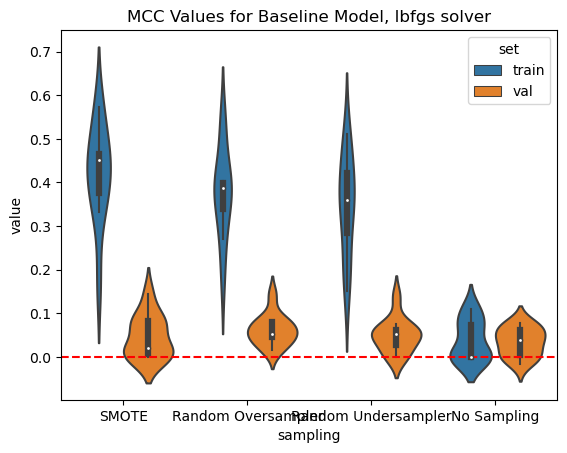

In [28]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, lbfgs solver')
plt.show()


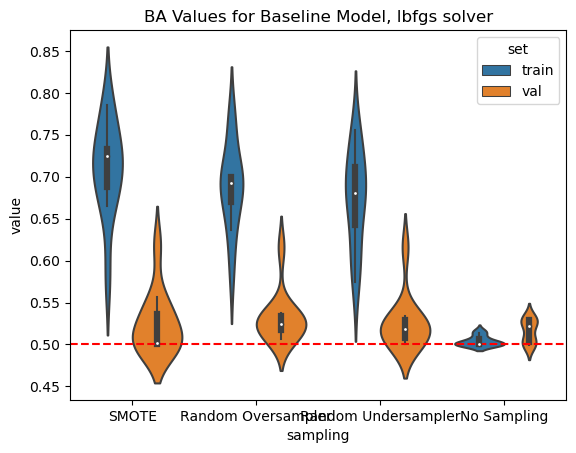

In [29]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, lbfgs solver')
plt.show()


#### liblinear

In [16]:
start_time = time.time()
model_liblinear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='liblinear', multiclass = True,))
end_time = time.time()
duration_liblinear = end_time-start_time
print(f"Operation took {duration_liblinear} seconds.")

Operation took 20192.85226225853 seconds.


In [18]:
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
84,SMOTE,Normalizer + StandardScaler,0.943,0.942,0.943,0.924,"[[2098, 150, 18, 0], [260, 1921, 56, 29], [0, ...",0.812,0.829,0.808,0.588,"[[63, 25, 9, 0], [103, 620, 15, 17], [2, 2, 64..."
326,RandomOverSampler,Normalizer + StandardScaler,0.932,0.932,0.932,0.910,"[[2036, 197, 33, 0], [275, 1892, 67, 32], [9, ...",0.805,0.824,0.795,0.579,"[[66, 22, 9, 0], [107, 614, 17, 17], [4, 3, 61..."
314,RandomOverSampler,Normalizer + MinMaxScaler,0.862,0.860,0.862,0.817,"[[1835, 303, 107, 21], [373, 1650, 119, 124], ...",0.745,0.775,0.794,0.527,"[[71, 17, 7, 2], [135, 551, 29, 40], [4, 1, 61..."
12,SMOTE,MaxAbsScaler,0.896,0.894,0.896,0.862,"[[1969, 225, 57, 15], [329, 1722, 100, 115], [...",0.754,0.784,0.787,0.529,"[[68, 20, 5, 4], [130, 563, 19, 43], [3, 1, 62..."
266,RandomOverSampler,MinMaxScaler,0.878,0.875,0.878,0.837,"[[1870, 287, 88, 21], [337, 1696, 106, 127], [...",0.749,0.779,0.785,0.520,"[[68, 21, 6, 2], [129, 559, 24, 43], [4, 1, 60..."
...,...,...,...,...,...,...,...,...,...,...,...,...
374,no_sampling,MaxAbsScaler,0.864,0.842,0.578,0.559,"[[80, 202, 10, 0], [22, 2217, 25, 2], [10, 60,...",0.079,0.088,0.246,0.017,"[[1, 0, 6, 90], [17, 39, 123, 576], [0, 0, 9, ..."
345,RandomOverSampler,MinMaxScaler + Normalizer,0.756,0.753,0.756,0.675,"[[1553, 404, 212, 97], [382, 1429, 160, 295], ...",0.187,0.192,0.244,-0.024,"[[81, 16, 0, 0], [597, 96, 61, 1], [51, 16, 1,..."
264,RandomOverSampler,MinMaxScaler,0.878,0.875,0.878,0.837,"[[1870, 287, 88, 21], [337, 1696, 106, 127], [...",0.736,0.679,0.243,-0.029,"[[5, 92, 0, 0], [51, 696, 8, 0], [1, 67, 0, 0]..."
110,SMOTE,StandardScaler + Normalizer,0.860,0.858,0.860,0.814,"[[1853, 294, 92, 27], [365, 1621, 108, 172], [...",0.057,0.044,0.243,0.006,"[[0, 0, 7, 90], [9, 17, 127, 602], [0, 0, 11, ..."


In [19]:
model_liblinear.to_csv('fb_lr_lbfgs.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
84,SMOTE,Normalizer + StandardScaler,0.943,0.942,0.943,0.924,"[[2098, 150, 18, 0], [260, 1921, 56, 29], [0, ...",0.812,0.829,0.808,0.588,"[[63, 25, 9, 0], [103, 620, 15, 17], [2, 2, 64..."
326,RandomOverSampler,Normalizer + StandardScaler,0.932,0.932,0.932,0.910,"[[2036, 197, 33, 0], [275, 1892, 67, 32], [9, ...",0.805,0.824,0.795,0.579,"[[66, 22, 9, 0], [107, 614, 17, 17], [4, 3, 61..."
314,RandomOverSampler,Normalizer + MinMaxScaler,0.862,0.860,0.862,0.817,"[[1835, 303, 107, 21], [373, 1650, 119, 124], ...",0.745,0.775,0.794,0.527,"[[71, 17, 7, 2], [135, 551, 29, 40], [4, 1, 61..."
12,SMOTE,MaxAbsScaler,0.896,0.894,0.896,0.862,"[[1969, 225, 57, 15], [329, 1722, 100, 115], [...",0.754,0.784,0.787,0.529,"[[68, 20, 5, 4], [130, 563, 19, 43], [3, 1, 62..."
266,RandomOverSampler,MinMaxScaler,0.878,0.875,0.878,0.837,"[[1870, 287, 88, 21], [337, 1696, 106, 127], [...",0.749,0.779,0.785,0.520,"[[68, 21, 6, 2], [129, 559, 24, 43], [4, 1, 60..."
...,...,...,...,...,...,...,...,...,...,...,...,...
374,no_sampling,MaxAbsScaler,0.864,0.842,0.578,0.559,"[[80, 202, 10, 0], [22, 2217, 25, 2], [10, 60,...",0.079,0.088,0.246,0.017,"[[1, 0, 6, 90], [17, 39, 123, 576], [0, 0, 9, ..."
345,RandomOverSampler,MinMaxScaler + Normalizer,0.756,0.753,0.756,0.675,"[[1553, 404, 212, 97], [382, 1429, 160, 295], ...",0.187,0.192,0.244,-0.024,"[[81, 16, 0, 0], [597, 96, 61, 1], [51, 16, 1,..."
264,RandomOverSampler,MinMaxScaler,0.878,0.875,0.878,0.837,"[[1870, 287, 88, 21], [337, 1696, 106, 127], [...",0.736,0.679,0.243,-0.029,"[[5, 92, 0, 0], [51, 696, 8, 0], [1, 67, 0, 0]..."
110,SMOTE,StandardScaler + Normalizer,0.860,0.858,0.860,0.814,"[[1853, 294, 92, 27], [365, 1621, 108, 172], [...",0.057,0.044,0.243,0.006,"[[0, 0, 7, 90], [9, 17, 127, 602], [0, 0, 11, ..."


In [17]:
model_liblinear_melted = pd.melt(model_liblinear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_liblinear_melted = model_liblinear_melted.drop(model_liblinear_melted[model_liblinear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_liblinear_melted['set'] = np.where(model_liblinear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_liblinear_melted['met'] = np.where(model_liblinear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_liblinear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_liblinear_melted['sampling'] = np.where(model_liblinear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_liblinear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_liblinear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_liblinear_melted = model_liblinear_melted.drop(columns=['metrics'])
model_liblinear_melted


,sampling,scaling,value,set,met
484,No Sampling,Normalizer + MaxAbsScaler,0.951,train,f1
485,Random Undersampler,Normalizer + MinMaxScaler,0.659,train,f1
486,Random Oversampler,Normalizer + MinMaxScaler,0.679,train,f1
487,Random Oversampler,Normalizer + MinMaxScaler,0.679,train,f1
488,Random Oversampler,MaxAbsScaler + Normalizer,0.649,train,f1
...,...,...,...,...,...
3867,Random Oversampler,StandardScaler,-0.112,val,mcc
3868,SMOTE,none,-0.009,val,mcc
3869,Random Oversampler,StandardScaler,-0.015,val,mcc
3870,Random Oversampler,Normalizer + StandardScaler,-0.023,val,mcc


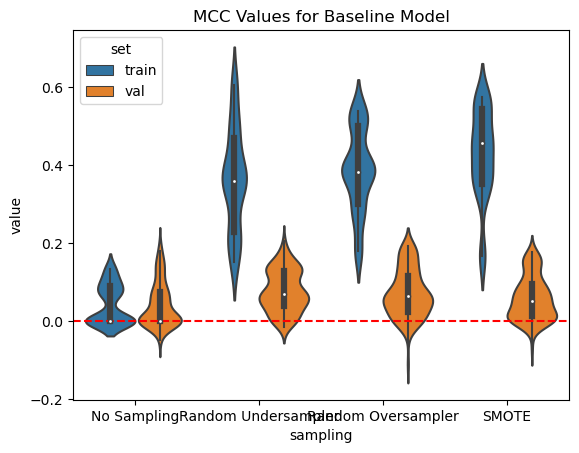

In [18]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model')
plt.show()


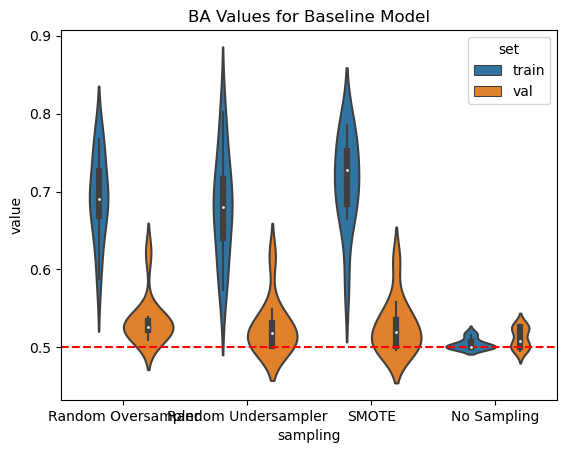

In [19]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model')
plt.show()


#### saga

In [20]:
start_time = time.time()
model_saga = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='saga'))#.to_csv('da_lr_saga.csv')
end_time = time.time()
duration_saga = end_time-start_time
print(f"Operation took {duration_saga} seconds.")
model_saga

Operation took 774.9750499725342 seconds.


,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
0,SMOTE,none,0.625,0.628,0.625,0.250,"[[1294, 805], [769, 1330]]",0.624,0.753,0.600,0.119,"[[41, 31], [259, 441]]"
22,RandomOverSampler,none,0.613,0.624,0.613,0.227,"[[1228, 871], [753, 1346]]",0.620,0.750,0.591,0.109,"[[40, 32], [261, 439]]"
11,RandomUnderSampler,none,0.624,0.629,0.624,0.249,"[[133, 84], [79, 138]]",0.587,0.721,0.579,0.093,"[[41, 31], [288, 412]]"
26,RandomOverSampler,Normalizer,0.588,0.543,0.588,0.179,"[[1440, 659], [1072, 1027]]",0.477,0.616,0.537,0.043,"[[44, 28], [376, 324]]"
1,SMOTE,MaxAbsScaler,0.731,0.725,0.731,0.463,"[[1582, 517], [612, 1487]]",0.159,0.136,0.536,0.085,"[[72, 0], [649, 51]]"
2,SMOTE,MinMaxScaler,0.734,0.727,0.734,0.468,"[[1591, 508], [609, 1490]]",0.155,0.128,0.534,0.083,"[[72, 0], [652, 48]]"
23,RandomOverSampler,MaxAbsScaler,0.701,0.700,0.701,0.403,"[[1483, 616], [638, 1461]]",0.155,0.128,0.534,0.083,"[[72, 0], [652, 48]]"
24,RandomOverSampler,MinMaxScaler,0.698,0.699,0.698,0.396,"[[1460, 639], [629, 1470]]",0.154,0.126,0.534,0.082,"[[72, 0], [653, 47]]"
30,RandomOverSampler,MaxAbsScaler + Normalizer,0.650,0.649,0.650,0.300,"[[1368, 731], [739, 1360]]",0.152,0.121,0.532,0.080,"[[72, 0], [655, 45]]"
37,no_sampling,Normalizer,0.906,0.951,0.500,0.000,"[[0, 217], [0, 2099]]",0.343,0.453,0.532,0.041,"[[55, 17], [490, 210]]"


In [21]:
model_saga.to_csv('fa_lr_saga.csv')

In [22]:
model_saga_melted = pd.melt(model_saga, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_saga_melted = model_saga_melted.drop(model_saga_melted[model_saga_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_saga_melted['set'] = np.where(model_saga_melted['metrics'].str.startswith('train'), 'train', 'val')
model_saga_melted['met'] = np.where(model_saga_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_saga_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_saga_melted['sampling'] = np.where(model_saga_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_saga_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_saga_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_saga_melted = model_saga_melted.drop(columns=['metrics'])
model_saga_melted


,sampling,scaling,value,set,met
44,SMOTE,none,0.628,train,f1
45,Random Oversampler,none,0.624,train,f1
46,Random Undersampler,none,0.629,train,f1
47,Random Oversampler,Normalizer,0.543,train,f1
48,SMOTE,MaxAbsScaler,0.725,train,f1
...,...,...,...,...,...
347,No Sampling,Normalizer + StandardScaler,0.000,val,mcc
348,No Sampling,MaxAbsScaler + Normalizer,0.000,val,mcc
349,No Sampling,MinMaxScaler + Normalizer,0.000,val,mcc
350,No Sampling,none,0.000,val,mcc


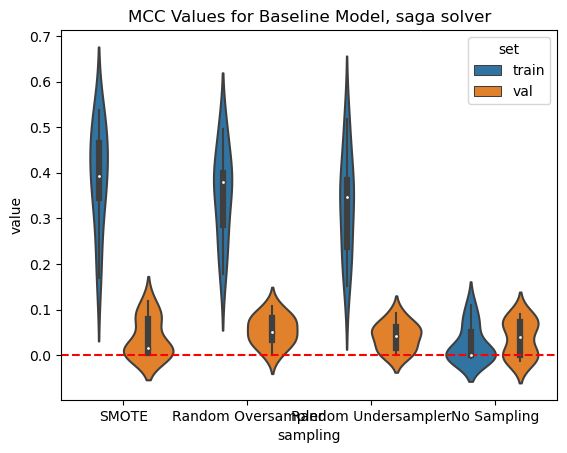

In [23]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.title('MCC Values for Baseline Model, saga solver')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


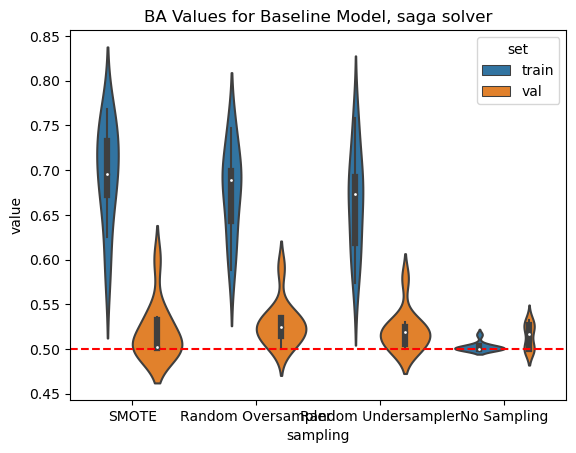

In [24]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, saga solver')
plt.show()


#### plot for all solvers

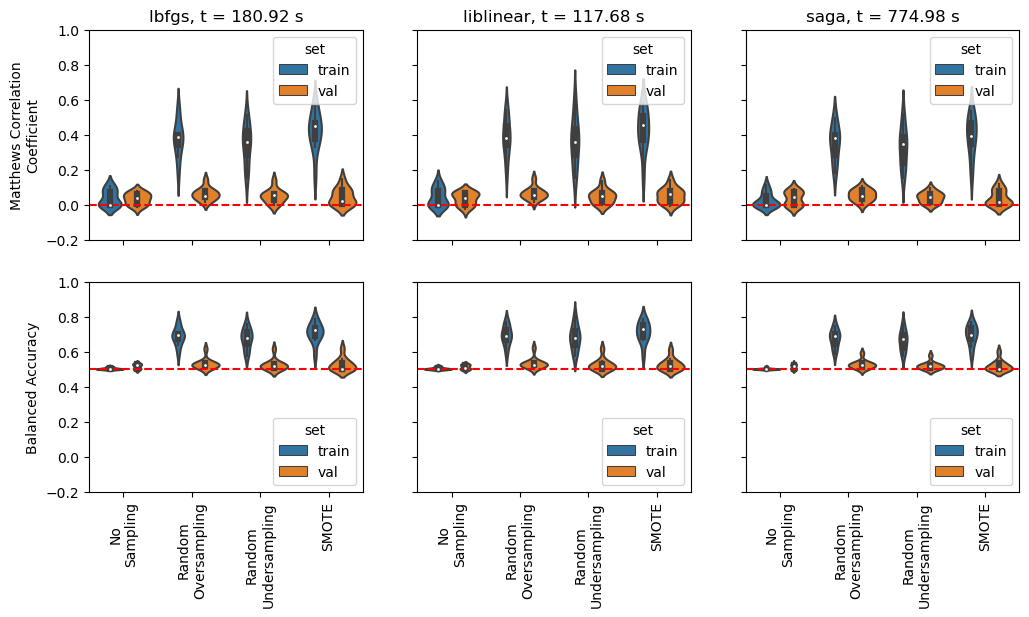

In [30]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'lbfgs, t = {round(duration_lbfgs, 2)} s')
ax[0, 1].set_title(f'liblinear, t = {round(duration_liblinear, 2)} s')
ax[0, 2].set_title(f'saga, t = {round(duration_saga, 2)} s')

for i, j in enumerate([model_lbfgs_melted, model_liblinear_melted, model_saga_melted]):
    sns.violinplot(data=j[j['met']=='mcc'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba']‚ x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

In [19]:
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,val_accuracy,val_f1,val_ba,val_mcc
22,RandomOverSampler,none,0.672,0.676,0.672,0.344,0.672,0.789,0.645,0.177
20,RandomUnderSampler,MinMaxScaler + Normalizer,0.631,0.628,0.631,0.263,0.564,0.696,0.629,0.150
19,RandomUnderSampler,MaxAbsScaler + Normalizer,0.611,0.610,0.611,0.221,0.560,0.693,0.620,0.140
43,no_sampling,StandardScaler + Normalizer,0.906,0.951,0.500,0.000,0.555,0.690,0.599,0.115
11,RandomUnderSampler,none,0.700,0.703,0.700,0.401,0.604,0.735,0.595,0.112
30,RandomOverSampler,MaxAbsScaler + Normalizer,0.620,0.627,0.620,0.240,0.516,0.652,0.590,0.105
31,RandomOverSampler,MinMaxScaler + Normalizer,0.628,0.634,0.628,0.256,0.525,0.662,0.582,0.096
0,SMOTE,none,0.688,0.686,0.688,0.375,0.647,0.773,0.581,0.099
15,RandomUnderSampler,Normalizer,0.599,0.601,0.599,0.198,0.722,0.831,0.579,0.105
26,RandomOverSampler,Normalizer,0.593,0.599,0.593,0.185,0.309,0.395,0.569,0.094


## feature importance

In [22]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fa)

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)

scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.659
balanced accuracy: 0.668
matthews corrcoeff: 0.337
cf:
[[151  66]
 [ 78 139]]

val scores 

f1: 0.715
balanced accuracy: 0.614
matthews corrcoeff: 0.134
cf:
[[ 47  25]
 [297 403]]


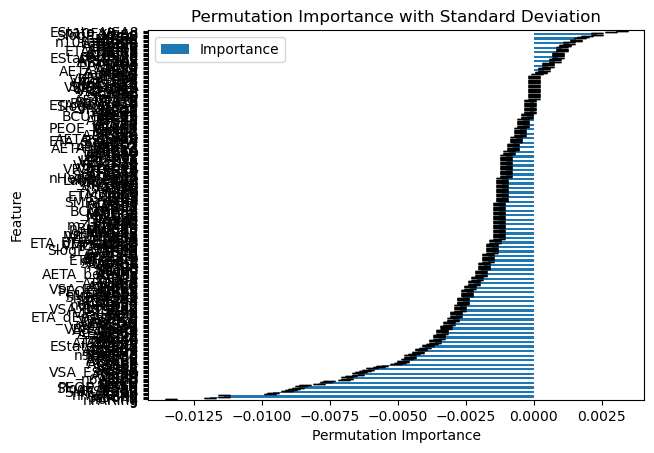

In [23]:
result = permutation_importance(fit, X_val, y_val, n_repeats=10, random_state=random_state)

feature_importance = pd.DataFrame({'Feature': descnm,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                             
                            yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')
plt.tight_layout
plt.show()

In [45]:
feature_importance[feature_importance['Importance'] > 0].Feature.to_list()

['fr_NH2',
 'NHOHCount',
 'fr_priamide',
 'PEOE_VSA1',
 'NumSaturatedHeterocycles',
 'fr_Ndealkylation1',
 'VSA_EState7',
 'fr_piperzine',
 'SMR_VSA4',
 'PEOE_VSA14',
 'SlogP_VSA3',
 'SlogP_VSA11',
 'SlogP_VSA8',
 'EState_VSA8',
 'SMR_VSA6',
 'SMR_VSA9',
 'PEOE_VSA8',
 'EState_VSA6',
 'PEOE_VSA11',
 'EState_VSA4',
 'SlogP_VSA2',
 'EState_VSA5']

### retrain

In [62]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da[features_])

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.593
balanced accuracy: 0.604
matthews corrcoeff: 0.209
cf:
[[127  74]
 [ 85 116]]

val scores 

f1: 0.159
balanced accuracy: 0.521
matthews corrcoeff: 0.047
cf:
[[ 64   3]
 [505  48]]


## hyperparameter tuning using gridsearch

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fb)

In [24]:
def grid_search(X_train, y_train,
                param_grid,
                algorithm = 'LogisticRegression',
                fold = 3,
                scoring='balanced_accuracy',
                random_state=0,
                ):
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(random_state=random_state)
    elif algorithm == 'SVC':
        model = SVC(random_state=random_state)
    elif algorithm == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=random_state)
    else:
        pass

    cv_ = model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=fold,
        verbose=3,
        scoring=scoring,
        )
    cv_.fit(X_train, y_train)

    return cv_.cv_results_, cv_.best_params_


In [25]:
param_grid = {
    'solver': ['liblinear', 'lbfgs', 'saga',],# 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'class_weight':[None, 'balanced'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'max_iter': [10000],
    'random_state':[0]
}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fb)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='LogisticRegression',)

cv_params

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.2s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=N

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.291 total time= 4.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.380 total time= 3.4min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_cl

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   3.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   3.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 1.4min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.2s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   1.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=  18.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=   7.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 2.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 3.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 4.5min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.291 total time= 4.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.380 total time= 4.6min
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, c

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   2.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   4.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 2.5min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.2s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.2s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_cla

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l2, random_state=0, solver=saga;, score=0.637 total time= 7.3min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanc

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   3.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   5.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   4.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 2.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 2.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time= 2.3min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=saga;, score=0.627 total time= 4.5min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, ma

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   1.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=  20.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=  10.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 5.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 4.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 3.2min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.637 total time= 3.7min
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=elasticnet, random_state=0, solver=lbfgs;, score=nan total time=   0.0s

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   3.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   1.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time= 1.5min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, rando

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   1.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 1.4min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.250 total time=   0.1s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=   7.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=   2.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 1.9min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 1.7min
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multino

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 1.8min
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.298 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.300 total time=   0.2s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.360 total time=   0.1s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   2.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   7.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=  12.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 3.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 3.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time= 2.9min
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.298 total time=   0.3s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.300 total time=   0.7s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.360 total time=   0.4s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.456 total time= 7.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=saga;, score=0.498 total time= 6.8min
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.725 total time=   1.1s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.652 total time=   1.1s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=liblinear;, score=0.682 total time=   1.3s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.725 total time=   3.3s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l2, random_state=0, solver=lbfgs;, score=0.602 total time=   0.9s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalt

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   1.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=  21.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=  10.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 6.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 6.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 7.9min
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_ite

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   2.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   8.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=  12.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 3.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 4.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time= 3.6min
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.388 total time=   0.4s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.366 total time=   0.5s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.472 total time=   0.3s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   3.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   5.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   7.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 3.2min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 3.5min
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.388 total time=   0.9s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.366 total time=   0.5s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.472 total time=   0.4s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=  19.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=  13.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 2.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 4.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 2.6min
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, p

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   9.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   2.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 2.9min
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.645 total time=   0.5s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.571 total time=   0.4s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.606 total time=   0.4s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penal

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   2.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   4.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 1.9min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 1.8min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time= 3.5min
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.645 total time=   0.9s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.571 total time=   0.7s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.606 total time=   0.5s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, ra

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   1.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=  10.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=   7.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 2.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 2.3min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 2.4min
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   4.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   2.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  53.2s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.558 total time=   0.4s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.488 total time=   0.5s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.651 total time=   0.5s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lb

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time=  57.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time=  50.0s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.566 total time=   1.6s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.491 total time=   1.8s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.626 total time=   1.9s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=   6.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=   2.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 1.4min
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   0.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time=  58.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time=  58.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time=  54.9s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.616 total time=   2.9s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.536 total time=   2.3s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.647 total time=   2.2s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   1.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time=  54.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  50.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  48.9s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.616 total time=   1.9s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.536 total time=   1.9s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.647 total time=   2.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_st

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=   5.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=   2.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 1.4min
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time=  54.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  50.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  48.5s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.563 total time=   3.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.488 total time=   3.6s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.632 total time=   3.0s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   0.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time=  59.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time=  50.3s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.563 total time=   3.5s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.488 total time=   3.2s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.632 total time=   3.3s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=   6.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=   2.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 1.6min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 1.4min
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, p

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time=  59.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time=  51.2s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.578 total time=   3.3s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.537 total time=   3.5s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.658 total time=   3.9s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penal

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   1.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time=  59.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  54.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  54.4s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.578 total time=   4.1s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.537 total time=   4.3s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.658 total time=   4.2s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, ra

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=   4.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=   2.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 1.4min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 1.3min
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time=  53.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  50.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  49.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.521 total time=254.9min
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.530 total time=   8.1s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.630 total time=   8.6s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, sol

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.2s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   4.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   3.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.648 total time= 2.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.521 total time=266.0min
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.530 total time=   3.7s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.630 total time=   3.4s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=sag

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.503 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.535 total time=   7.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.656 total time=   4.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.598 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.459 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.666 total time= 1.7min
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multino

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.579 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.666 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.580 total time= 1.1min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.648 total time=  56.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.526 total time=135.6min
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.549 total time=   4.6s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=liblinear;, score=0.629 total time=   6.5s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, pen

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  58.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=auto, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  52.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.526 total time=138.2min
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.549 total time=   4.6s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=liblinear;, score=0.629 total time=   6.8s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=l1

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.443 total time=   0.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.516 total time=   5.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=lbfgs;, score=0.560 total time=   4.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.680 total time= 1.7min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.686 total time= 1.5min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=ovr, penalty=None, random_state=0, solver=saga;, score=0.658 total time= 1.5min
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1000, class_weight=balanced, max_ite

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.533 total time=   0.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=   1.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.660 total time=   2.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.719 total time= 1.0min


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.647 total time=  55.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.681 total time=  59.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
714 fits failed out of a total of 1512.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solv

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'saga'}

In [26]:
fb_lr_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
fb_lr_cv_iter_1.to_csv('fb_lr_cv_iter_1.csv', index=False)
fb_lr_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
197,98.826433,34.690506,0.003683,0.000981,0.1,balanced,10000,ovr,l2,0,saga,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.722661,0.693909,0.678272,0.698281,0.018384,1
257,46.847122,4.323234,0.002437,0.000011,1,balanced,10000,auto,l2,0,saga,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.718979,0.657212,0.690631,0.688941,0.025245,2
281,47.079557,4.014273,0.002476,0.000057,1,balanced,10000,multinomial,l2,0,saga,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.718979,0.657212,0.690631,0.688941,0.025245,2
326,89.820651,4.381865,0.002899,0.000636,10,balanced,10000,auto,l1,0,saga,"{'C': 10, 'class_weight': 'balanced', 'max_ite...",0.723815,0.647334,0.692623,0.687924,0.031400,4
350,88.273610,3.486321,0.002453,0.000025,10,balanced,10000,multinomial,l1,0,saga,"{'C': 10, 'class_weight': 'balanced', 'max_ite...",0.723815,0.647334,0.692623,0.687924,0.031400,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.005145,0.000148,0.000000,0.000000,1000,balanced,10000,multinomial,l2,0,liblinear,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
498,0.004225,0.000136,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,liblinear,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
499,0.003960,0.000270,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,lbfgs,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267
500,0.004282,0.000631,0.000000,0.000000,1000,balanced,10000,multinomial,elasticnet,0,saga,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,267


## test

In [27]:
solver='saga'
max_iter=10000
random_state=0
C=0.1
penalty='l2'
class_weight=None
multi_class='ovr'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_fb)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
print('finished sampling')
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
print('finished normalizing train')
X_val = scaler.transform(X_val)
print('finished normalizing val')
X_test = scaler.transform(X_test)
print('finished normalizing test')
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
print('finished scaling train')
X_val = scaler.transform(X_val)
print('finished scaling validation')
X_test = scaler.transform(X_test)
print('finished scaling test')

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty, class_weight=class_weight, multi_class=multi_class)
fit = lr.fit(X_train, y_train)
print('finished fitting')
y_pred = fit.predict(X_train)
print('finished predicting train')
y_val_pred = fit.predict(X_val)
print('finished predicting val')
y_test_pred = fit.predict(X_test)
print('finished predicting test')

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'weighted')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
#print(f'TEST scores \n')
#print(f'f1: {test_f1:.3f}')
#print(f'balanced accuracy: {test_ba:.3f}')
#print(f'matthews corrcoeff: {test_mcc:.3f}')
#print(f'cf:\n{test_cf}')
#print('')


# svm

In [98]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

## linear

In [10]:
start_time = time.time()
model_linear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='linear'))
model_linear.to_csv('da_svm_linear.csv')
end_time = time.time()
duration_linear = end_time-start_time
print(f"Operation took {duration_linear} seconds.")

In [ ]:
model_linear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
0,SMOTE,none,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
4,SMOTE,Normalizer,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
11,RandomUnderSampler,none,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
15,RandomUnderSampler,Normalizer,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
22,RandomOverSampler,none,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
26,RandomOverSampler,Normalizer,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
33,no_sampling,none,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
37,no_sampling,Normalizer,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
8,SMOTE,MaxAbsScaler + Normalizer,0.627,0.616,0.627,0.254,"[[142, 75], [87, 130]]",0.549,0.680,0.633,0.154,"[[53, 19], [329, 370]]"
9,SMOTE,MinMaxScaler + Normalizer,0.627,0.616,0.627,0.254,"[[142, 75], [87, 130]]",0.549,0.680,0.633,0.154,"[[53, 19], [329, 370]]"


In [ ]:
model_linear_melted = pd.melt(model_linear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_linear_melted = model_linear_melted.drop(model_linear_melted[model_linear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_linear_melted['set'] = np.where(model_linear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_linear_melted['met'] = np.where(model_linear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_linear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_linear_melted['sampling'] = np.where(model_linear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_linear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_linear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_linear_melted = model_linear_melted.drop(columns=['metrics'])#.sort_values(['sampling', 'set'])
model_linear_melted


,sampling,scaling,value,set,met
44,SMOTE,none,0.626,train,f1
45,SMOTE,Normalizer,0.626,train,f1
46,Random Undersampler,none,0.626,train,f1
47,Random Undersampler,Normalizer,0.626,train,f1
48,Random Oversampler,none,0.626,train,f1
...,...,...,...,...,...
347,Random Oversampler,Normalizer + MinMaxScaler,-0.001,val,mcc
348,No Sampling,MaxAbsScaler,-0.001,val,mcc
349,No Sampling,MinMaxScaler,-0.001,val,mcc
350,No Sampling,Normalizer + MaxAbsScaler,-0.001,val,mcc


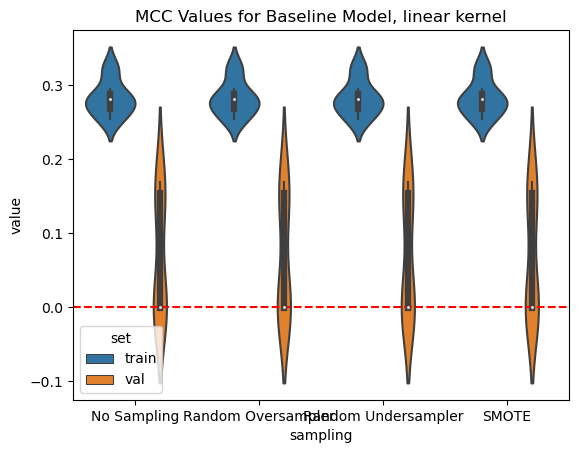

In [94]:
sns.violinplot(data=model_linear_melted[model_linear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


## poly

In [ ]:
start_time = time.time()
model_poly = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='poly'))
model_poly.to_csv('da_svm_poly.csv')
end_time = time.time()
duration_poly = end_time-start_time
print(f"Operation took {duration_poly} seconds.")

Operation took 4.201333999633789 seconds.


In [ ]:
model_poly_melted = pd.melt(model_poly, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_poly_melted = model_poly_melted.drop(model_poly_melted[model_poly_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_poly_melted['set'] = np.where(model_poly_melted['metrics'].str.startswith('train'), 'train', 'val')
model_poly_melted['met'] = np.where(model_poly_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_poly_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_poly_melted['sampling'] = np.where(model_poly_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_poly_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_poly_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_poly_melted = model_poly_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_poly_melted


,sampling,scaling,value,set,met
47,No Sampling,StandardScaler + Normalizer,0.910,train,f1
54,No Sampling,StandardScaler,0.747,train,f1
55,No Sampling,Normalizer + StandardScaler,0.747,train,f1
62,No Sampling,none,0.796,train,f1
63,No Sampling,Normalizer,0.796,train,f1
...,...,...,...,...,...
329,SMOTE,MinMaxScaler + Normalizer,-0.012,val,mcc
336,SMOTE,MaxAbsScaler,-0.016,val,mcc
337,SMOTE,MinMaxScaler,-0.016,val,mcc
338,SMOTE,Normalizer + MaxAbsScaler,-0.016,val,mcc


## rbf

In [ ]:
start_time = time.time()
model_rbf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='rbf'))
model_rbf.to_csv('da_svm_rbf.csv')
end_time = time.time()
duration_rbf = end_time-start_time
print(f"Operation took {duration_rbf} seconds.")

Operation took 8.249082803726196 seconds.


In [ ]:
model_rbf

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
10,SMOTE,StandardScaler + Normalizer,0.832,0.826,0.832,0.665,"[[188, 29], [44, 173]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
21,RandomUnderSampler,StandardScaler + Normalizer,0.832,0.826,0.832,0.665,"[[188, 29], [44, 173]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
32,RandomOverSampler,StandardScaler + Normalizer,0.832,0.826,0.832,0.665,"[[188, 29], [44, 173]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
43,no_sampling,StandardScaler + Normalizer,0.832,0.826,0.832,0.665,"[[188, 29], [44, 173]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
3,SMOTE,StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
7,SMOTE,Normalizer + StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
14,RandomUnderSampler,StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
18,RandomUnderSampler,Normalizer + StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
25,RandomOverSampler,StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"
29,RandomOverSampler,Normalizer + StandardScaler,0.802,0.790,0.802,0.607,"[[186, 31], [55, 162]]",0.093,0.0,0.5,0.0,"[[72, 0], [699, 0]]"


In [ ]:
model_rbf_melted = pd.melt(model_rbf, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_rbf_melted = model_rbf_melted.drop(model_rbf_melted[model_rbf_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_rbf_melted['set'] = np.where(model_rbf_melted['metrics'].str.startswith('train'), 'train', 'val')
model_rbf_melted['met'] = np.where(model_rbf_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_rbf_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_rbf_melted['sampling'] = np.where(model_rbf_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_rbf_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_rbf_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_rbf_melted = model_rbf_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_rbf_melted


,sampling,scaling,value,set,met
47,No Sampling,StandardScaler + Normalizer,0.826,train,f1
54,No Sampling,StandardScaler,0.790,train,f1
55,No Sampling,Normalizer + StandardScaler,0.790,train,f1
62,No Sampling,none,0.715,train,f1
63,No Sampling,Normalizer,0.715,train,f1
...,...,...,...,...,...
329,SMOTE,MinMaxScaler,0.000,val,mcc
330,SMOTE,Normalizer + MaxAbsScaler,0.000,val,mcc
331,SMOTE,Normalizer + MinMaxScaler,0.000,val,mcc
344,SMOTE,MaxAbsScaler + Normalizer,0.000,val,mcc


## sigmoid

In [ ]:
start_time = time.time()
model_sigmoid = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='sigmoid'))
model_sigmoid.to_csv('da_svm_sigmoid.csv')
end_time = time.time()
duration_sigmoid = end_time-start_time
print(f"Operation took {duration_sigmoid} seconds.")

Operation took 6.985504865646362 seconds.


In [ ]:
model_sigmoid_melted = pd.melt(model_sigmoid, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_sigmoid_melted = model_sigmoid_melted.drop(model_sigmoid_melted[model_sigmoid_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_sigmoid_melted['set'] = np.where(model_sigmoid_melted['metrics'].str.startswith('train'), 'train', 'val')
model_sigmoid_melted['met'] = np.where(model_sigmoid_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_sigmoid_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_sigmoid_melted['sampling'] = np.where(model_sigmoid_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_sigmoid_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_sigmoid_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_sigmoid_melted = model_sigmoid_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_sigmoid_melted


,sampling,scaling,value,set,met
47,No Sampling,StandardScaler + Normalizer,0.575,train,f1
54,No Sampling,StandardScaler,0.507,train,f1
55,No Sampling,Normalizer + StandardScaler,0.507,train,f1
62,No Sampling,none,0.221,train,f1
63,No Sampling,Normalizer,0.221,train,f1
...,...,...,...,...,...
329,SMOTE,MinMaxScaler,0.000,val,mcc
330,SMOTE,Normalizer + MaxAbsScaler,0.000,val,mcc
331,SMOTE,Normalizer + MinMaxScaler,0.000,val,mcc
344,SMOTE,MaxAbsScaler + Normalizer,0.000,val,mcc


## plot for all kernels

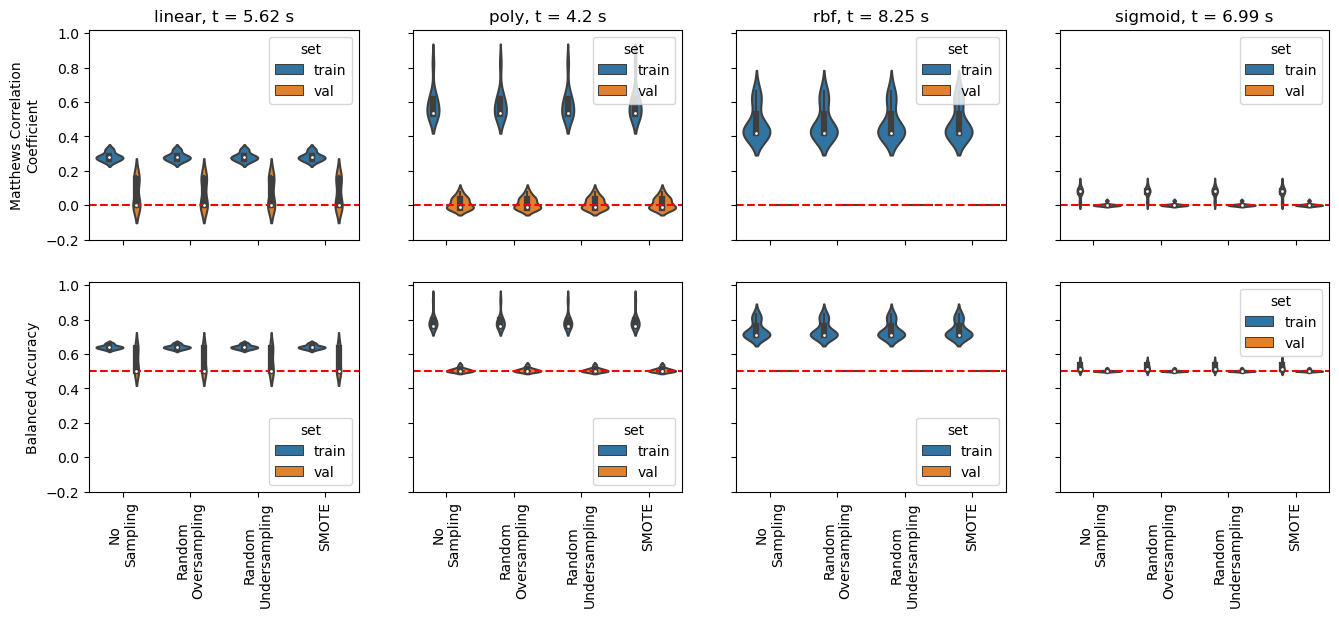

In [93]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'linear, t = {round(duration_linear, 2)} s')
ax[0, 1].set_title(f'poly, t = {round(duration_poly, 2)} s')
ax[0, 2].set_title(f'rbf, t = {round(duration_rbf, 2)} s')
ax[0, 3].set_title(f'sigmoid, t = {round(duration_sigmoid, 2)} s')

for i, j in enumerate([model_linear_melted, model_poly_melted, model_rbf_melted, model_sigmoid_melted]):
    sns.violinplot(data=j[j['met']=='mcc'], x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'], x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

## feature importance

## hyperparameter tuninr

# rf